In [8]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [9]:
import rdkit
import pandas as pd
import numpy as np

from src import models
from src import experimental_setup
from src.helpers import init_layer, count_cf_bonds

from sklearn.preprocessing import StandardScaler
import multiprocessing

# Experimental set-up

In [10]:
mordred = models.DNN_Mordred
sampling_type = 'random'

kfold = experimental_setup.CrossValidator(
    splits = 5, # dont change without re-running data preprocessing
    sampling_type = sampling_type
)

converter = experimental_setup.LD50UnitConverter()

# Transfer learning from base model

Our objective is to repurpose knowledge learned a source task (toxicity forecasting in *LDToxDB* chemical space) for use within desired target domain of *PFAS* toxicity prediction. We do this by retraining a model which demonstrated appreciable performance in the source domain to our target domain. Because labelled data are limited within our explicit target domain, we expand target task learning to any compound within LDToxDb which has 2 or more $C-F$ bonds.

Benchmark models were evaluated for their performance of predicting LDToxDB. The best performing NN from benchmarking is loaded as a checkpoint to use as a base model. The transfer step involves applying some set of modifications to the base model before retraining on target task data. Some techniques include adjusting learning rate, re-initialize MLP layers (randomize weights), freezing MLP layer weights. We reduce the learning rate by 10 and attempt several combinations of layer freezing and layer reinitialization.

<table>
    <tr style='font-weight:bold'><td>Level</td><td>Unfreeze last X hidden layers layers</td><td>Reinitialize last X hidden layers?</td></tr>
    <tr><td>1</td><td>1</td><td>No</td></tr>
    <tr><td>2</td><td>1</td><td>Yes</td></tr>
    <tr><td>3</td><td>2</td><td>No</td></tr>
    <tr><td>4</td><td>2</td><td>Yes</td></tr>
    <tr><td>5</td><td>3</td><td>No</td></tr>
    <tr><td>6</td><td>3</td><td>Yes</td></tr>
    <tr><td>7</td><td>4</td><td>No</td></tr>
    <tr><td>8</td><td>4</td><td>Yes</td></tr>
</table>

In [5]:
mordred_encoding = 'mordred'

def fit_model(fold_no, train, test, fold_no2, train_all, test_all):
    print('Training %d' % fold_no)
    
    scaler = StandardScaler()
    scaler2 = StandardScaler()
    
    x_train, y_train, smiles_train = train
    x_test, y_test, smiles_test = test
    x_train_all, y_train_all, smiles_train_all = train_all
    
    scaler.fit(y_train_all)
    y_train = scaler.transform(y_train)
    
    scaler2.fit(x_train_all)
    x_train = scaler2.transform(x_train)
    
    model = models.DNN()
    model.learning_rate = 0.004663515283240011
    model.n_layers = 3
    model.layer_size = 128
    model.batch_size = 256
    model.epochs = 1000
    
    model.fit(x_train, y_train, verbose=0)
    
    #save model
    fn = 'dnn_mordred' + str(fold_no) + '_' + sampling_type + '_base_pfaslikeexcluded'
    model.save_weights(os.path.abspath('../data/transfer-learning/chkpts/%s.chkpt' % fn))
    
    print('Completed %d' % fold_no)
    
processes = []
with multiprocessing.Pool(5) as pool:
    for (fold_no, (train, test)), (fold_no2, (train_all, test_all))\
        in zip(enumerate(kfold.get_folds(mordred_encoding, 'pfas_like_excluded')),\
                                        enumerate(kfold.get_folds(mordred_encoding, 'pfas_excluded'))):
        
        processes.append(pool.apply_async(fit_model, [fold_no, train, test, fold_no2, train_all, test_all]))
    
    while sum(task.ready() for task in processes) != len(processes):
        foo = 1

Training 0
Training 1
Training 2
Training 3
Training 4
Completed 3
Completed 2
Completed 0
Completed 1
Completed 4


In [6]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

results_agg = pd.DataFrame()

mordred_encoding = 'mordred'
for (fold_no, (train, test)), (fold_no2, (train_all, test_all))\
    in zip(enumerate(kfold.get_folds(mordred_encoding, 'pfas_like_excluded')),\
                                    enumerate(kfold.get_folds(mordred_encoding, 'pfas_excluded'))):
    x_train, y_train, smiles_train = train
    x_train_all, y_train_all, smiles_train_all = train_all
    x_test_all, y_test_all, smiles_test_all = test_all

    experimental_setup.scaler.fit(y_train_all)
    experimental_setup.scaler2.fit(x_train_all)
    
    x_test_all = experimental_setup.scaler2.transform(x_test_all)

    # Locate base model from benchmarks
    fn = 'dnn_mordred' + str(fold_no) + '_' + sampling_type + '_base_pfaslikeexcluded'
    model_path = '../data/transfer-learning/chkpts/%s.chkpt' % fn

    # Load weights file
    model = models.DNN()
    model.learning_rate = 0.004663515283240011
    model.n_layers = 3
    model.layer_size = 128
    model.batch_size = 256
    
    model.build(input_shape=x_train.shape)
    model.load_weights(model_path)
    
    y_hat = experimental_setup.scaler.inverse_transform(model.predict(x_test_all))

    results = pd.DataFrame({
        'smiles': smiles_test_all.flatten(),
        'prediction_neglogld50': y_hat.flatten(),
        'prediction_mgkg': converter.convert_to_mgkg(y_hat, smiles_test_all),
        'prediction_epa': converter.convert_to_epa(y_hat, smiles_test_all),
        'actual_neglogld50': y_test_all.flatten(),
        'actual_mgkg': converter.convert_to_mgkg(y_test_all, smiles_test_all),
        'actual_epa': converter.convert_to_epa(y_test_all, smiles_test_all),
    })
    
    results.to_csv('../data/transfer-learning/%s_predictions.csv' % fn)
    
    results_agg = results_agg.append(results)

In [4]:
mordred_encoding = 'mordred'

def fit_model(epochs, level, fold_no, train, test, fold_no2, train_all, test_all):
    print('Training %d (epochs %d, level %d)' % (fold_no, epochs, level))
    scaler = StandardScaler()
    scaler2 = StandardScaler()
    
    x_train, y_train, smiles_train = train
    x_test, y_test, smiles_test = test
    x_train_all, y_train_all, smiles_train_all = train_all

    scaler.fit(y_train_all)
    y_train = scaler.transform(y_train)
    scaler2.fit(x_train_all)
    x_train = scaler2.transform(x_train)
    x_test = scaler2.transform(x_test)

    # Locate base model from benchmarks
    fn = 'dnn_mordred' + str(fold_no) + '_' + sampling_type
    model_path = '../data/transfer-learning/chkpts/%s_base_pfaslikeexcluded.chkpt' % fn

    # Load weights file
    model = models.DNN()
    model.learning_rate = 0.004663515283240011
    model.n_layers = 3
    model.layer_size = 128
    model.batch_size = 256
    model.build(input_shape=x_train.shape)
    model.load_weights(model_path)

    # Modification to base model
    model.epochs = epochs

    last_x_layers = int(-2*np.floor(level / 2)) - 1

    for layer in model.layers[:last_x_layers]:
        layer.trainable = False

    if level % 2 == 1:
        for layer in model.layers[last_x_layers:]:
            init_layer(layer)

    model.fit(x_train.astype(np.float32), y_train, verbose=0)

    # Save model
    fn += '_level' + str(level) + '_epochs' + str(epochs)
    model.save_weights(os.path.abspath('../data/transfer-learning/chkpts/%s' % fn))

    y_hat = scaler.inverse_transform(model.predict(x_test))

    results = pd.DataFrame({
        'smiles': smiles_test.flatten(),
        'prediction_neglogld50': y_hat.flatten(),
        'prediction_mgkg': converter.convert_to_mgkg(y_hat, smiles_test),
        'prediction_epa': converter.convert_to_epa(y_hat, smiles_test),
        'actual_neglogld50': y_test.flatten(),
        'actual_mgkg': converter.convert_to_mgkg(y_test, smiles_test),
        'actual_epa': converter.convert_to_epa(y_test, smiles_test),
    })

    results.to_csv('../data/transfer-learning/%s_predictions.csv' % fn)
    
    print('Completed %d (epochs %d, level %d)' % (fold_no, epochs, level))
    
processes = []
with multiprocessing.Pool(30) as pool:
    for epochs in [100, 500]:
        for level in range(0,8):
            for (fold_no, (train, test)), (fold_no2, (train_all, test_all))\
                in zip(enumerate(kfold.get_folds(mordred_encoding, 'pfas_like_pfas_excluded')),\
                                                enumerate(kfold.get_folds(mordred_encoding, 'pfas_excluded'))):
                #fit_model(epochs, level, fold_no, train, test, fold_no2, train_all, test_all)
                processes.append(pool.apply_async(fit_model, [epochs, level, fold_no, train, test, fold_no2, train_all, test_all]))
    
    while sum(task.ready() for task in processes) != len(processes):
        foo = 1

Training 0 (epochs 100, level 0)
Training 1 (epochs 100, level 0)
Training 2 (epochs 100, level 0)
Training 3 (epochs 100, level 0)
Training 4 (epochs 100, level 0)
Training 0 (epochs 100, level 1)
Training 1 (epochs 100, level 1)
Training 2 (epochs 100, level 1)
Training 3 (epochs 100, level 1)
Training 4 (epochs 100, level 1)
Training 0 (epochs 100, level 2)
Completed 0 (epochs 100, level 0)
Completed 1 (epochs 100, level 0)
Training 1 (epochs 100, level 2)
Training 2 (epochs 100, level 2)
Completed 2 (epochs 100, level 0)
Training 3 (epochs 100, level 2)
Training 4 (epochs 100, level 2)
Completed 3 (epochs 100, level 0)
Training 0 (epochs 100, level 3)
Completed 4 (epochs 100, level 0)
Training 1 (epochs 100, level 3)
Completed 0 (epochs 100, level 1)
Training 2 (epochs 100, level 3)
Completed 1 (epochs 100, level 1)
Training 3 (epochs 100, level 3)
Completed 2 (epochs 100, level 1)
Training 4 (epochs 100, level 3)
Completed 3 (epochs 100, level 1)
Training 0 (epochs 100, level 4)
C

Takes some work to compile results in the way necessary for visualization.

# Results comparison

In [3]:
from glob import glob
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from rdkit import Chem

result_paths = glob('../data/transfer-learning/dnn_mordred*base_pfaslikeexcluded*.csv')
                    
# Aggregated results from base model (benchmark model)

levels_aggregated = pd.DataFrame()

for path in result_paths:
    print(path)
    results = pd.read_csv(path)
    
    # Only look at PFAS results from the benchmark models; others are irrelevant for target task
    results['rd_mol'] = results.smiles.apply(Chem.MolFromSmiles)
    results['is_pfas_like'] = results.rd_mol.apply(count_cf_bonds) >= 2
    results = results.loc[results.is_pfas_like]
    
    levels_aggregated = levels_aggregated.append({
        'epoch': -1,
        'level': -1,
        'mae': mean_absolute_error(results['actual_neglogld50'], results['prediction_neglogld50'])
    }, ignore_index=True)

# Aggregated results from transfer learning models  
for epochs in [100, 500]:
    for level in range(0,8):
        result_paths = glob('../data/transfer-learning/*_level%s_epochs%s_predictions*' % (level, epochs))
        
        print(len(result_paths))
        if len(result_paths)>5:
            print(result_paths)

        folds_aggregated = pd.DataFrame()

        for path in result_paths:
            results = pd.read_csv(path)

            levels_aggregated = levels_aggregated.append({
                'epoch': epochs,
                'level': level,
                'mae': mean_absolute_error(results['actual_neglogld50'], results['prediction_neglogld50'])
            }, ignore_index=True)

../data/transfer-learning/retuned/dnn_mordred3_random_base_pfaslikeexcluded_predictions.csv
../data/transfer-learning/retuned/dnn_mordred2_random_base_pfaslikeexcluded_predictions.csv
../data/transfer-learning/retuned/dnn_mordred0_random_base_pfaslikeexcluded_predictions.csv
../data/transfer-learning/retuned/dnn_mordred4_random_base_pfaslikeexcluded_predictions.csv
../data/transfer-learning/retuned/dnn_mordred1_random_base_pfaslikeexcluded_predictions.csv
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


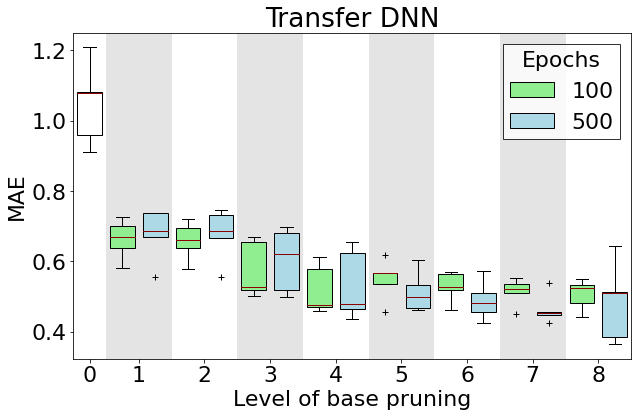

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

plt.figure(facecolor='white', figsize=(10,6), dpi=72)
plt.rc('font', weight='normal', size=22, family='Arial')

groupings = levels_aggregated.groupby(by=['level', 'epoch'])
bplot = plt.boxplot(groupings.mae.apply(list).values, patch_artist=True, widths=0.75, sym='+', medianprops={'color':'darkred'})
plt.xticks([1] + list(np.arange(2.5, 17.5, 2)), labels=list(range(0, 9)))

plt.title('Transfer DNN')
plt.ylabel('MAE')
plt.xlabel('Level of base pruning')

j = 0
for patch, (i, df) in zip(bplot['boxes'], groupings):
    j += 1
    
    #Making background, colors, etc.. distinctive
    if df['epoch'].iloc[0] == 100:
        patch.set_facecolor('lightgreen')
        
        if j % 4 == 1:
            rect = patches.Rectangle((0.5+j,0.24), 2, 1.5, facecolor='lightgrey', edgecolor='none', alpha=0.6)
            plt.gca().add_patch(rect)
            
    elif df['epoch'].iloc[0] == 500:
        patch.set_facecolor('lightblue')
        
    else:
        j -= 1
        patch.set_facecolor('white')

plt.legend((Patch(facecolor='lightgreen', edgecolor='black'), Patch(facecolor='lightblue', edgecolor='black')),
           ('100', '500'),
           title='Epochs', loc='upper right', edgecolor='black', borderpad=0.3, fancybox=False)

In [5]:
def std_s(x):
    return np.std(x, ddof=1)

levels_aggregated.pivot_table(index=['level', 'epoch'], aggfunc=[np.mean, std_s])

mean     std_s
                   mae       mae
level epoch                     
-1.0  -1.0    1.048083  0.117174
 0.0   100.0  0.662493  0.056683
       500.0  0.677368  0.075262
 1.0   100.0  0.658753  0.054089
       500.0  0.676877  0.074969
 2.0   100.0  0.573921  0.081438
       500.0  0.602934  0.091509
 3.0   100.0  0.518886  0.070593
       500.0  0.531425  0.099704
 4.0   100.0  0.548641  0.060514
       500.0  0.513155  0.058529
 5.0   100.0  0.528017  0.042916
       500.0  0.488835  0.056346
 6.0   100.0  0.513856  0.039498
       500.0  0.464018  0.043978
 7.0   100.0  0.506386  0.043543
       500.0  0.483645  0.112710

We conclude that transfer learning via small adjustments to the base model results in a positive transfer of knowledge to the target domain.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


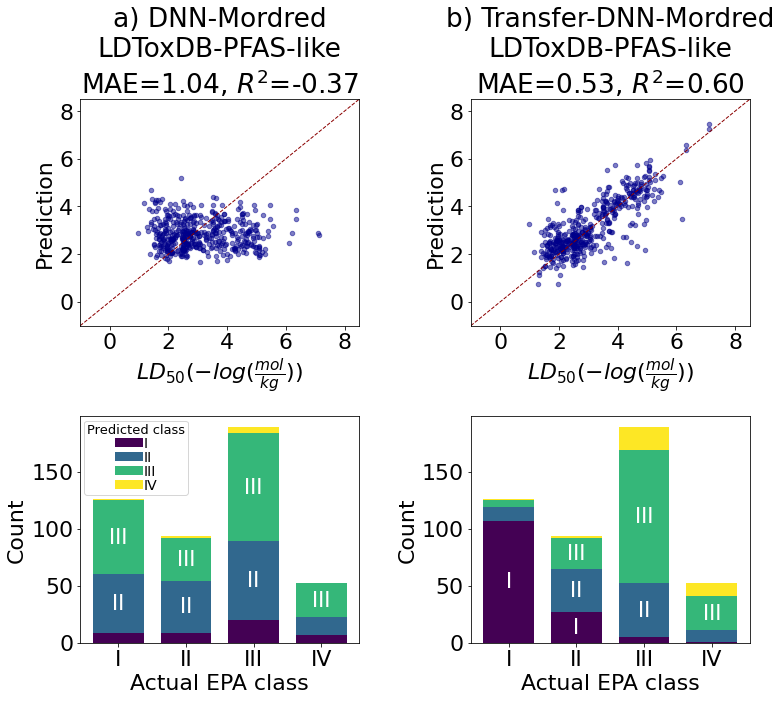

In [6]:
import matplotlib
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=72)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.rc('figure', facecolor='white')
plt.rc('font', family='Arial', weight='normal')
plt.rc('axes', labelsize=22, facecolor='white')
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=20)

baseline_results = pd.concat([pd.read_csv(path)
                        for path in glob('../data/transfer-learning/dnn_mordred*base_pfaslikeexcluded*.csv')])

# Regression plots--

# Only look at PFAS results from the benchmark models; others are irrelevant for target task
baseline_results['rd_mol'] = baseline_results.smiles.apply(Chem.MolFromSmiles)
baseline_results['is_pfas_like'] = baseline_results.rd_mol.apply(count_cf_bonds) >= 2
baseline_results = baseline_results.loc[baseline_results.is_pfas_like]

pfas_mae = mean_absolute_error(baseline_results['actual_neglogld50'], baseline_results['prediction_neglogld50'])
pfas_r2 = r2_score(baseline_results['actual_neglogld50'], baseline_results['prediction_neglogld50'])

axes[0][0].scatter(baseline_results['actual_neglogld50'], baseline_results['prediction_neglogld50'], s=20,
                alpha = 0.5, color='darkblue')
#y=x
axes[0][0].plot([0,1],[0,1], transform=axes[0][0].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
axes[0][0].set_title('a) DNN-Mordred\nLDToxDB-PFAS-like\n' + 'MAE=%0.2f, $R^2$=%0.2f' % (pfas_mae, pfas_r2))
axes[0][0].set_xlabel("$LD_{50} (-log(\\frac{mol}{kg})$)")
axes[0][0].set_ylabel("Prediction")
axes[0][0].set_xlim((-1,8.5))
axes[0][0].set_ylim((-1, 8.5))
axes[0][0].set_xticks([0,2,4,6,8])

transfer_results = pd.concat([pd.read_csv(path)
                        for path in glob('../data/transfer-learning/dnn_mordred*_random*level5_epochs100_*.csv')])

pfas_mae = mean_absolute_error(transfer_results['actual_neglogld50'], transfer_results['prediction_neglogld50'])
pfas_r2 = r2_score(transfer_results['actual_neglogld50'], transfer_results['prediction_neglogld50'])

axes[0][1].scatter(transfer_results['actual_neglogld50'], transfer_results['prediction_neglogld50'], s=20,
                  alpha = 0.5, color='darkblue')
#y=x
axes[0][1].plot([0,1],[0,1], transform=axes[0][1].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
axes[0][1].set_title('b) Transfer-DNN-Mordred\nLDToxDB-PFAS-like\n' + 'MAE=%0.2f, $R^2$=%0.2f' % (pfas_mae, pfas_r2))
axes[0][1].set_xlabel("$LD_{50} (-log(\\frac{mol}{kg})$)")
axes[0][1].set_ylabel("Prediction")
axes[0][1].set_xlim((-1,8.5))
axes[0][1].set_ylim((-1, 8.5))
axes[0][1].set_xticks([0,2,4,6,8])

# Confusion plots--

levels = ['I','II','III','IV']

cm = confusion_matrix(baseline_results['actual_epa'].values, baseline_results['prediction_epa'].values)

for i, pred_level in enumerate(levels):
    for j, level in enumerate(levels):
            if pred_level == level:
                axes[1][0].bar(j, cm[j][i], bottom=np.sum(cm[j][:i]), width=0.75,
                               label=pred_level, color=matplotlib.cm.get_cmap('viridis')(i/3), edgecolor='none')
            else:
                axes[1][0].bar(j, cm[j][i], bottom=np.sum(cm[j][:i]), width=0.75,
                               color=matplotlib.cm.get_cmap('viridis')(i/3), edgecolor='none')
                               
            if cm[j][i] > 500/20:
                axes[1][0].text(j, np.sum(cm[j][:i])+cm[j][i]*0.5, pred_level, ha='center',  va='center', color='white', size='21')

axes[1][0].set_xticks([0,1,2,3])
axes[1][0].set_xticklabels(levels)
axes[1][0].set_xlabel("Actual EPA class")
axes[1][0].set_ylabel("Count")

cm = confusion_matrix(transfer_results['actual_epa'].values, transfer_results['prediction_epa'].values)

for i, pred_level in enumerate(levels):
    for j, level in enumerate(levels):
            if pred_level == level:
                axes[1][1].bar(j, cm[j][i], bottom=np.sum(cm[j][:i]), width=0.75,
                               label=pred_level, color=matplotlib.cm.get_cmap('viridis')(i/3), edgecolor='none')
            else:
                axes[1][1].bar(j, cm[j][i], bottom=np.sum(cm[j][:i]), width=0.75,
                               color=matplotlib.cm.get_cmap('viridis')(i/3), edgecolor='none')
                               
            if cm[j][i] > 500/20:
                axes[1][1].text(j, np.sum(cm[j][:i])+cm[j][i]*0.5, pred_level, ha='center',  va='center', color='white', size='21')

axes[1][1].set_xticks([0,1,2,3])
axes[1][1].set_xticklabels(levels)
axes[1][1].set_xlabel("Actual EPA class")
axes[1][1].set_ylabel("Count")

axes[1][0].legend(loc='upper left', fontsize=14, labelspacing=0, borderaxespad=0.3,
                  columnspacing=0.1, borderpad=0.2, handletextpad=0.1,title='Predicted class',title_fontsize='13')